In [8]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
## read data 
hfont = {'fontname':'Helvetica'}
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


(2000.0, 2020.0)
(0.0, 0.5)


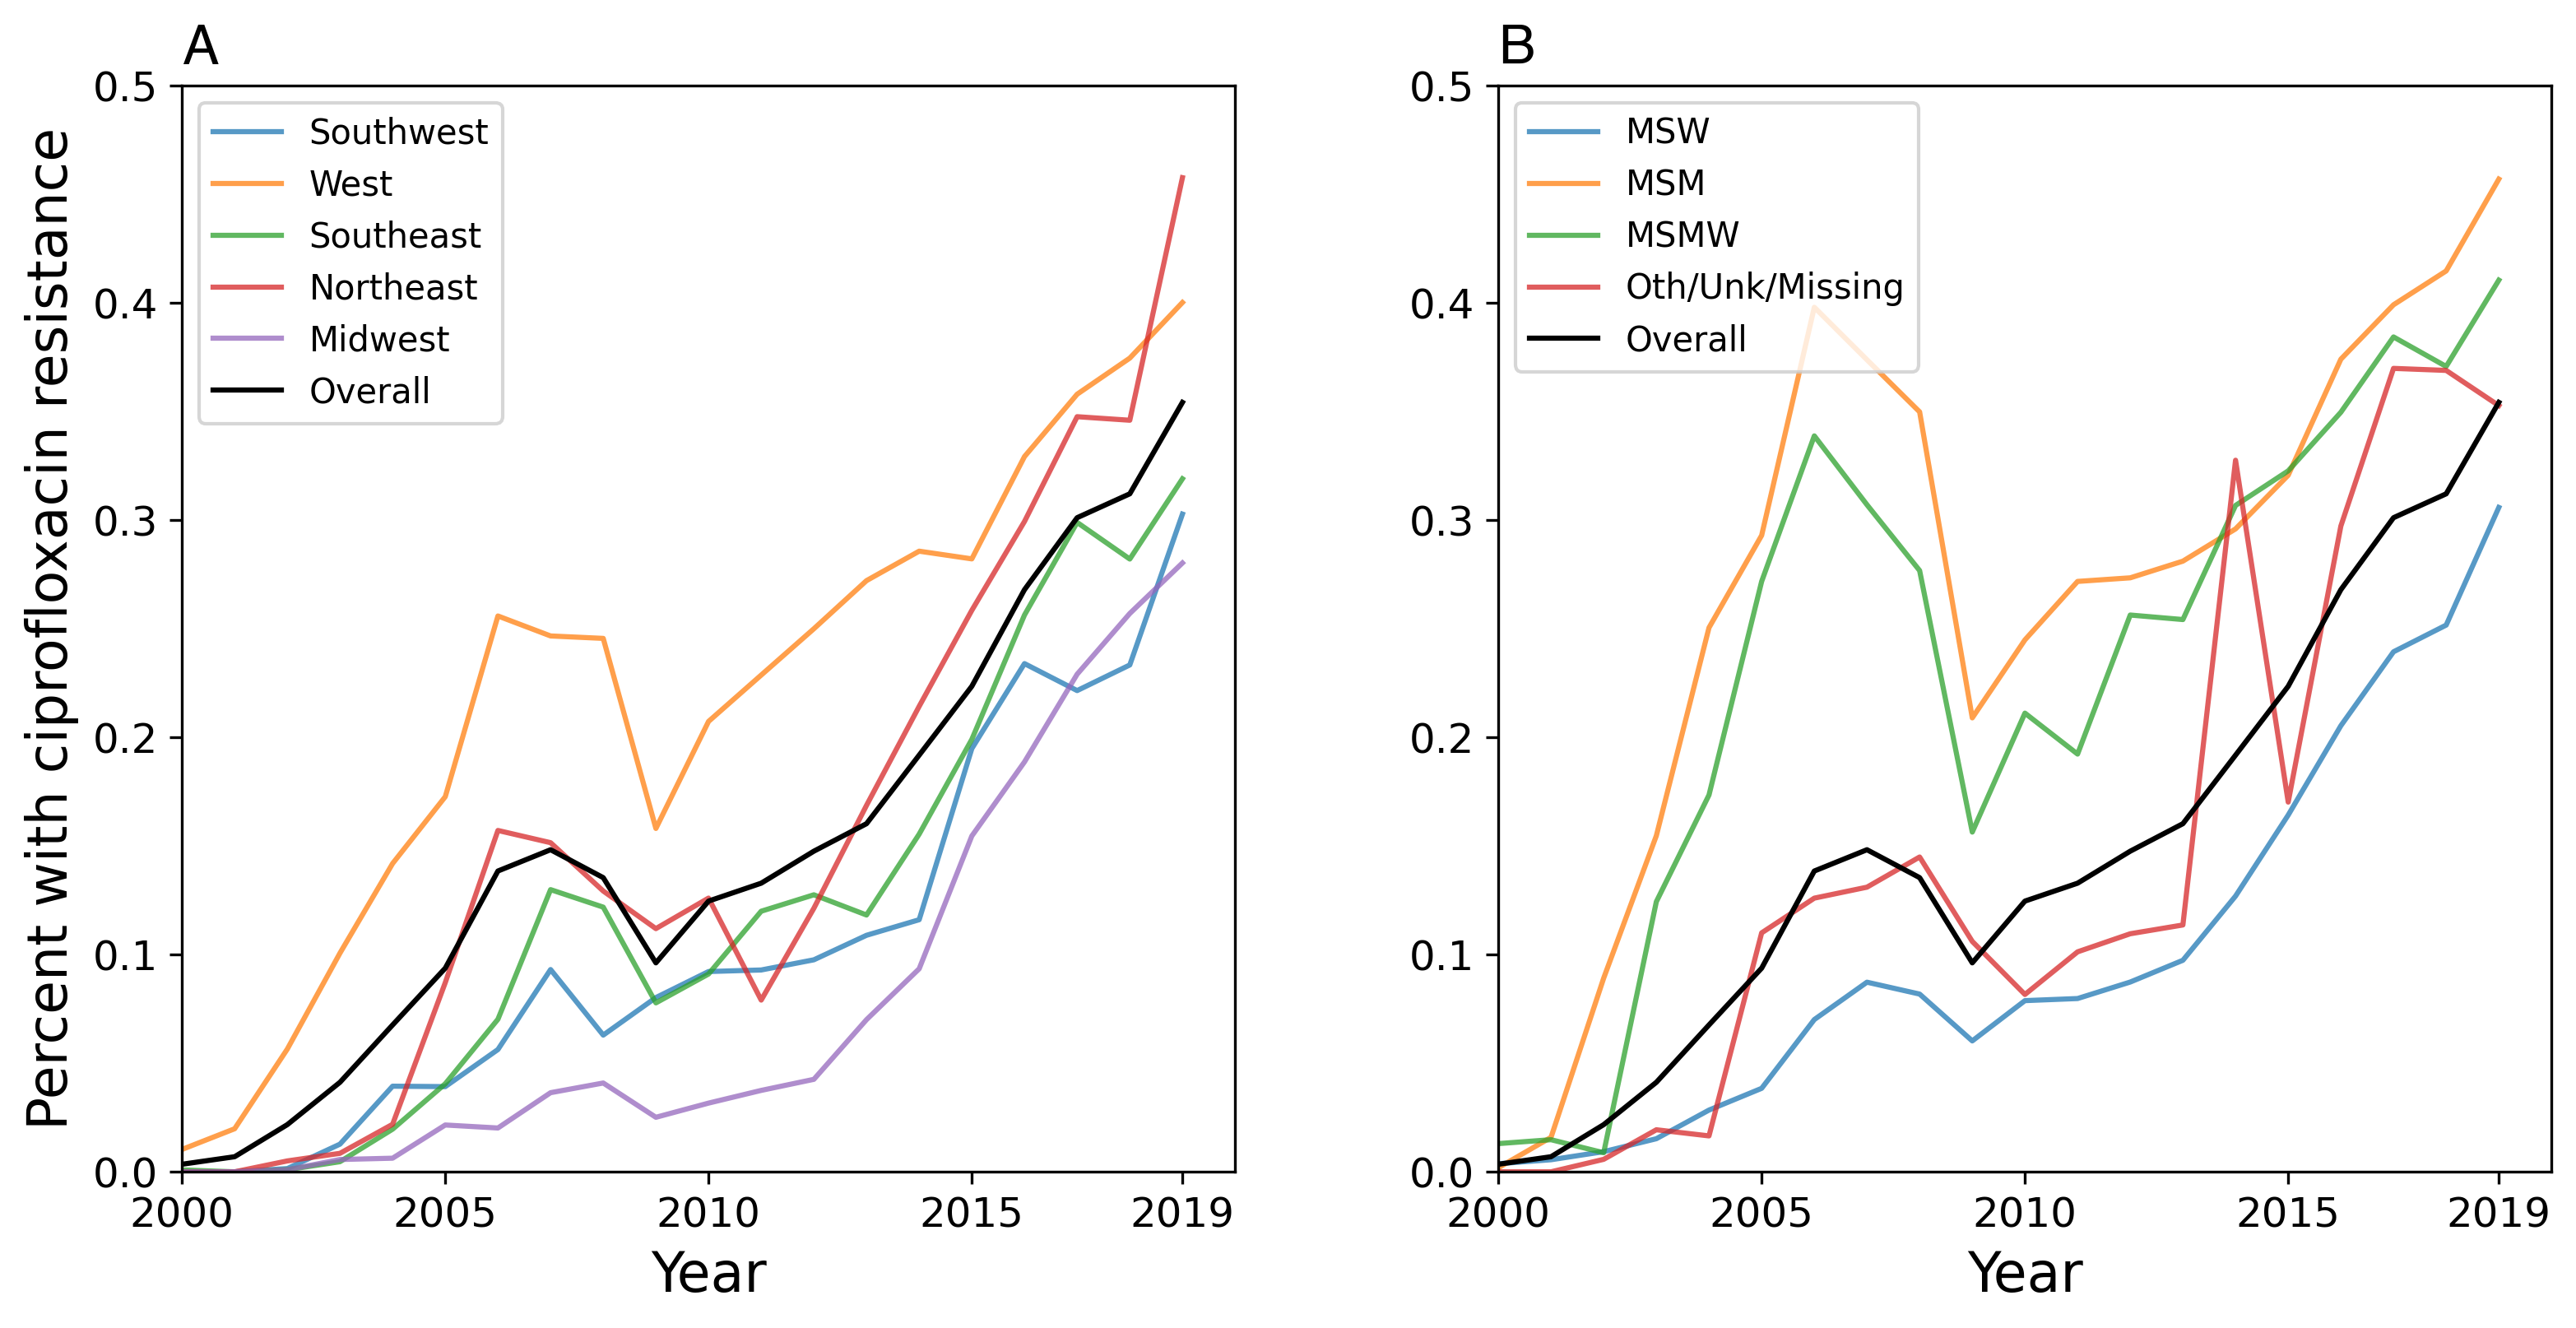

In [66]:
########### GRAPH SHOWING TRENDS IN RESISTANCE ###########
### Overall data 
xAxisYears = [2000, 2005, 2010, 2015, 2019]
years = CIP_data_no_drop["YEAR"].unique()
reistance_by_year_overall = []
reistance_by_year_all = pd.DataFrame() 
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    reistance_by_year_overall.append(1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.setp(ax1, xlim=(2000, 2020), ylim=(0,.50), xticks=[2000, 2005, 2010, 2015, 2019])
plt.setp(ax2, xlim=(2000, 2020), ylim=(0,.50), xticks=[2000, 2005, 2010, 2015, 2019])
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=1.4)
## By region

regions = CIP_data_no_drop["REGION"].unique()

plt.subplot(1, 2, 1) 
#plt.subplots(figsize=(7.5, 3.75))

for region in regions:
    CIP_data_region = CIP_data_no_drop.loc[CIP_data_no_drop['REGION'] == region]
    reistance_by_year = []
    for year in years:
        CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == year]

        reistance_by_year.append(1 - CIP_data_region_year["Susceptible"].sum()/len(CIP_data_region_year))
    ax1.plot(years, reistance_by_year, label=region, alpha=0.75)

ax1.plot(years, reistance_by_year_overall, color = "black", label = "Overall")

legend_labels = [regions, 'Overall']


### By gender of sp 
genders = CIP_data_no_drop["GENDERSP"].unique()

plt.subplot(1, 2, 1) 
#plt.subplots(figsize=(7.5, 3.75))

#reistance_by_year_all = pd.DataFrame()
for gender in genders:
    CIP_data_region = CIP_data_no_drop.loc[CIP_data_no_drop['GENDERSP'] == gender]
    reistance_by_year = []
    for year in years:
        CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == year]

        reistance_by_year.append(1 - CIP_data_region_year["Susceptible"].sum()/len(CIP_data_region_year))
        
    ax2.plot(years, reistance_by_year, label=gender, alpha=0.75)

ax2.plot(years, reistance_by_year_overall, color = "black", label = "Overall")

legend_labels = [genders, 'Overall']
ax1.set_xlabel('Year', fontsize = 16.0)
ax1.set_ylabel('Percent with ciprofloxacin resistance', fontsize = 16.0)
ax2.set_xlabel('Year', fontsize = 16.0)
ax1.legend()
ax2.legend(loc="upper left")
#ax1.annotate("A", xy=(0, 0.51), xycoords=trans,annotation_clip=False)
ax1.text(ax1.get_xlim()[0] , ax1.get_ylim()[1] + 0.01, 'A', fontsize = 16, **hfont)
ax2.text(ax1.get_xlim()[0] , ax1.get_ylim()[1] + 0.01, 'B', fontsize = 16, **hfont)

#ax1.set_title('ax1 title')
#ax2.set_title('ax2 title')

#plt.tight_layout()
print(ax1.get_xlim())
print(ax1.get_ylim())

plt.savefig('Trends_in_ciprofloxacin_reisistance_region_gendersp.png')
